# __Trabalho Prático 1 - Classificador Supervisionado__

Desenvolvendo um classificador supervisionado utilizando conceitos de geometria computacional para cumprir essa tarefa.

#### __Disciplina:__ Algoritmos II

#### __Grupo:__
Vinicius Silva Gomes - 2021421869

Mirna Mendonça e Silva - 2021421940

Daniel Barreto Torres - 2018432952

---

## __Introdução__
O objetivo principal do trabalho é implementar um classificador supervisionado a partir de conceitos e algoritmos de geometria computacional. Assim, dado dois conjuntos de pontos no plano e suas respectivas classificações, devemos construir uma regressão linear a partir dos conjuntos e classificar novas amostras desconhecidas. Esses conjuntos podem ser arbitrários ou vindos de datasets externos. A título deste trabalho, será apresentado, inicialmente, um exemplo mais simples, com poucos pontos e de modo que todo o processo possa ser amplamente distrinchado e entendido e, após isso, uma etapa de experimentação com datasets externos vindos do repositório de datasets KEEL, visando avaliar a qualidade do método de classificação proposto.

Nesse arquivo encontram-se o código fonte de todas funções executadas pelo programa, assim como a explicação de cada uma delas (em alto ou baixo nível, de acordo com a necessidade), além da documentação de como foi feita a Modelagem Computacional do problema, como funcionou a etapa de Experimentação e, por fim, quais foram as Conclusões e os Resultados obtidos ao final dos experimentos. Para executar o programa basta executar cada célula presente neste _notebook_ e avaliá-lo a partir dos retornos do código/gráficos e resultados.

## __Modelagem Computacional__
Para construir um classificador baseado em algoritmos geométricos utilizando apenas os atributos dos conjuntos de dados, foi utilizada uma abordagem muito simples. Primeiramente serão definidas as envoltórias convexas para cada classe do conjunto, considerando uma 2-tupla de atributos do dataset (coordenadas X e Y para definir um ponto no plano). Após isso, haverá a verificação se essas envoltórias são linearmente separáveis. Caso não sejam, é sinal de que é impossível classificar as amostras baseando-se nos atributos escolhidos. Caso sejam, significa que a reta de regressão pode ser traçada e que novas amostras podem ser classificadas a partir dela. Desse modo, a reta de regressão será definida a partir dos pontos mais próximos entre as envoltórias. A reta que cruza o ponto médio do segmento definido por esses pontos, construindo um ângulo de 90º com o segmento, será a regressão linear que irá possibilitar a classificação de amostras cujo _ground truth_ não seja conhecido.

Para simplificar e generalizar o acesso aos atributos de cada conjunto de dados, a classe ___Sample___ foi criada contendo as coordenadas (x, y) da posição da amostra no plano e o _ground truth_ para aquela amostra. Dessa forma, o acesso a esses atributos pode ser generalizado, o que facilita a manipulação dos datasets, visto que cada um deles teria nomes de atributos diferentes destinados a cada um dos eixos do plano. De fato, na fase de experimentação, um dos primeiros passos é mapear todas as instâncias do dataset para uma instância de Sample, facilitando demais a manipulação dos pontos e a execução dos métodos.

Definidas as classes principais para representar os pontos, podem ser estudados, então, os algoritmos geométricos utilizados em cada etapa do processo de classificação. Para computar as envoltórias convexas, será utilizado o algoritmo Graham Scan, que é capaz de montar a envoltória convexa para um conjunto arbitrário de pontos em tempo $\mathcal{O}(n \log{}n)$. De maneira simplificada, o Graham Scan ordena os pontos do conjunto a partir da coordenada polar em relação a um âncora definido previamente (elemento com menor coordenada y e mais a esquerda), e insere os pontos do conjunto em uma pilha, seguindo o critério de que toda nova inserção deve realizar um giro anti-horário em relação aos dois elementos anteriores na pilha. Caso o giro seja em sentido horário, o elemento ao topo da pilha deve ser desempilhado e a comparação é refeita, até que um giro em sentido anti-horário seja obtido. Dessa forma, após processar todos os pontos, o algoritmo garante que o polígono formado será convexo e que todos os pontos que não são vértices dele, se encontram dentro do polígono.

Além desse algoritmo, para verificar se as duas envoltórias são linearmente separáveis, podemos utilizar o algoritmo de varredura linear para verificar interseção entre um conjunto de segmentos. Desse modo, as duas envoltórias serão linearmente separáveis apenas se as únicas interseções presentes no conjunto de segmentos que definem ambas as envoltórias forem entre os segmentos da própria envoltória. Esse algoritmo é capaz de fazer isso a partir da ordenação dos segmentos e, além disso, utiliza uma árvore binária balanceada (AVL ou Rubro-Negra, por exemplo) para facilitar as comparações que são necessárias. Assim, no total, a complexidade temporal do algoritmo, assim como para o Graham Scan, é $\mathcal{O}(n \log{}n)$.

Para realizar essas comutações, especialmente as comparações de coordenadas polares e a separabilidade linear das envoltórias, serão utilizadas apenas as primitivas geométricas (posição relativa entre segmentos e o método para verificar se há interseção entre dois segmentos), de modo a evitar ao máximo divisões, funções trigonométricas, etc; evitando, com isso, imprecisões numéricas e problemas como _underflow_ e/ou _overflow_. Essas primitivas serão melhor destrinchadas no código fonte, através de pequenos comentários ou de textos mais extensos, quando necessário.


## __Implementação__
A implementação da solução para o problema foi feita em Python e o códugo fonte para as funções produzidas pode ser observado a seguir. 

In [188]:
# Importando bibliotecas e configurações iniciais

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import cmp_to_key

from math import sqrt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys

plt.rcParams['figure.figsize']  = (12, 6)
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 1

plt.ion()
plt.style.use('seaborn-colorblind')

### __Classes Principais__

In [44]:
# Definição da classe Sample e Segment

class Sample:
    def __init__(self, x = None, y = None, label = None):
        self.x = x
        self.y = y
        self.label = label
        
    def __str__(self):
        return f"({self.x}, {self.y}) - {self.label}"
    
class Segment:
    def __init__(self, terminal_a = None, terminal_b = None, start_terminal = None):
        self.terminal_a = start
        self.terminal_b = end

### __Métodos Auxiliares e de Visualização__

In [207]:
# Métodos para visualização das etapas da classificação

# Plota os dois conjuntos no plano
def plot_sets(set_a, set_b, label_a = "", label_b = "", title = "Conjuntos no plano"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    plt.xlim([min(item.x for item in set_a + set_b) - 2, max(item.x for item in set_a + set_b) + 2])
    plt.ylim([min(item.y for item in set_a + set_b) - 2, max(item.y for item in set_a + set_b) + 2])
        
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()
    
# Plota os conjuntos e a envoltória convexa de cada conjunto no plano
def plot_hulls(set_a, set_b, hull_a, hull_b, label_a = "", label_b = "", title = "Envoltórias Convexas no plano"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    hull_a.append(hull_a[0])
    hull_b.append(hull_b[0])
    
    plt.plot([item.x for item in hull_a], [item.y for item in hull_a], "-g")
    plt.plot([item.x for item in hull_b], [item.y for item in hull_b], "-b")
    
    plt.xlim([min(item.x for item in set_a + set_b) - 2, max(item.x for item in set_a + set_b) + 2])
    plt.ylim([min(item.y for item in set_a + set_b) - 2, max(item.y for item in set_a + set_b) + 2])
    
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()
    
def plot_classifier(set_a, set_b, hull_a, hull_b, b0, b1, point_a, point_b, label_a = "", label_b = "", title = "Envoltórias e Regressão Linear no plano"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    hull_a.append(hull_a[0])
    hull_b.append(hull_b[0])
    
    plt.plot([item.x for item in hull_a], [item.y for item in hull_a], "-g")
    plt.plot([item.x for item in hull_b], [item.y for item in hull_b], "-b")
    
    plt.plot([point_a.x, point_b.x], [point_a.y, point_b.y], "ok")
    plt.plot([point_a.x, point_b.x], [point_a.y, point_b.y], "-k")
    
    midpoint = ((point_a.x + (point_b.x - point_a.x) / 2), (point_a.y + (point_b.y - point_a.y) / 2))
    
    line_x = np.linspace(min(item.x for item in set_a + set_b) - 2, max(item.x for item in set_a + set_b) + 2, 100)
    line_y = b1 * line_x + b0
    
    plt.plot(midpoint[0], midpoint[1], "ok")
    plt.plot(line_x, line_y, '-r')
    
    plt.xlim([min(item.x for item in set_a + set_b) - 2, max(item.x for item in set_a + set_b) + 2])
    plt.ylim([min(item.y for item in set_a + set_b) - 2, max(item.y for item in set_a + set_b) + 2])
    
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()

In [190]:
# Métodos auxiliares

# Posição relativa do segmento pr em relação ao segmento pq
def relative_position(p, q, r):
    # Produto vetorial dos segmentos pq e pr
    pos = ((r.x - q.x) * (q.y - p.y)) - ((r.y - q.y) * (q.x - p.x))
    
    if pos == 0:
        return 0 # colinear
    elif pos > 0:
        return 1 # sentido horário
    else:
        return -1 # sentido antihorário

## Envoltória Convexa

def find_minor_point(points):
    index = -1
    min_y = sys.maxsize
    
    for idx, point in enumerate(points):
        if point.y < min_y:
            index = idx
            min_y = point.y
        elif point.y == min_y:
            if point.x < points[index].x:
                index = idx
                
    return (points[index], index)

def euclidean_distance(p1, p2):
    distance = sqrt(((p1.x - p2.x) ** 2) + ((p1.y - p2.y) ** 2))
    
    return distance
    
def polar_sort(p0, p1, p2):
    relative_pos = relative_position(p0, p1, p2)
    
    if relative_pos == 0:
        if euclidean_distance(p0, p1) < euclidean_distance(p0, p2):
            return -1
        else:
            return 1
    else:
        if relative_pos < 0:
            return -1
        else:
            return 1
    
def next_to_top(hull):
    return hull[-2]

def top(hull):
    return hull[-1]

## Varredura linear

# Verifica se um ponto está contido dentro de um segmento
def on_segment(p, q, r):
    if r.x >= min(p.x, q.x) and r.x <= max(p.x, q.x):
        if r.y >= min(p.y, q.y) and r.y <= max(p.y, q.y):
            return True
    
    return False

# Verifica se dois segmentos se intersectam
def segments_intersect(p1, p2, p3, p4):
    d1 = relative_position(p3, p4, p1)
    d2 = relative_position(p3, p4, p2)
    d3 = relative_position(p1, p2, p3)
    d4 = relative_position(p1, p2, p4)
    
    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True
    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False

### __Métodos Principais__

In [191]:
# Métodos principais

# Calcula a envoltória convexa para o conjunto de pontos dados
def graham_scan(points):
    # Encontra p0 no conjunto de dados
    p0, idx = find_minor_point(points)
    
    # Troca o p0 de lugar elemento de índice 0 do conjunto
    points[0], points[idx] = points[idx], points[0]
    
    # Ordena os elementos restantes a partir da coordenada polar com relação ao elemento p0
    sorted_points = points.copy()
    sorted_points[1:] = sorted(points[1:], key=cmp_to_key(lambda p1, p2: polar_sort(p0, p1, p2)))
    
    # Remove os pontos que possuem o mesmo ângulo polar em relação a p0 (mantém o que está mais longe)
    # inserir essa parte do código aqui
    
    if(len(sorted_points) < 3):
        print("É impossível montar uma envoltória convexa com o conjunto de pontos fornecido!")
        return
    
    hull = []
    hull.append(sorted_points[0])
    hull.append(sorted_points[1])
    hull.append(sorted_points[2])
    
    for i in range(3, len(sorted_points)):
        while ((len(hull) > 1) and (relative_position(next_to_top(hull), top(hull), sorted_points[i]) != -1)):
            hull.pop()
            
        hull.append(sorted_points[i])
    
    return hull

# Algoritmo da varredura linear para detectar interseção entre um conjunto de pontos
def line_sweep_intersection(points):
    len(points)

# Algoritmo para verificar se dois conjuntos de pontos são linearmente separável
def hulls_are_linearly_separable(hull_a, hull_b):
    return False

# Algoritmo para a construção do classificador
def make_classifier(hull_a, hull_b, label_a, label_b):
    min_distance = sys.maxsize
    points = (None, None)
    
    # Seleciona os dois pontos, um de cada conjunto, que possuem a menor distância euclidiana entre si
    for point_a in hull_a:
        for point_b in hull_b:
            distance = euclidean_distance(point_a, point_b)

            if distance < min_distance:
                min_distance = distance
                points = (point_a, point_b)
                
    # Recupera os pontos mais próximos em cada conjunto
    point_a, point_b = points

    if point_b.x - point_a.x == 0:
        b1 = 0
    else:
        # Calcula o coeficiente angular da reta
        b1 = -(1 / ((point_b.y - point_a.y) / (point_b.x - point_a.x)))
    
    # Calcula o coeficiente linear da reta
    b0 = (point_a.y + (point_b.y - point_a.y) / 2) - b1 * (point_a.x + (point_b.x - point_a.x) / 2)
    
    y_a_hat = b1 * point_a.x + b0
    y_b_hat = b1 * point_b.x + b0
    
    if point_a.y == y_a_hat or point_b.y == y_b_hat:
        print("Os pontos mais próximos de cada conjunto estão em cima da reta do classificador!")
        return
    
    up_label = ""
    down_label = ""
    
    if point_a.y < y_a_hat:
        up_label = point_b.label
        down_label = point_a.label
    else:
        up_label = point_a.label
        down_label = point_b.label
    
    # Retorna o coeficiente linear, o coeficiente angular, qual a classificação das amostras acima da reta e abaixo
    return b0, b1, point_a, point_b, up_label, down_label

# Utiliza os coeficientes da regressão linear para classificar uma amostra
def classify_sample(b0, b1, up_label, down_label, sample):
    y_hat = b1 * sample.x + b0
    
    if sample.y == y_hat:
        return False
    elif sample.y < y_hat:
        return down_label
    else:
        return up_label

#### __Exemplo básico do Classificador__

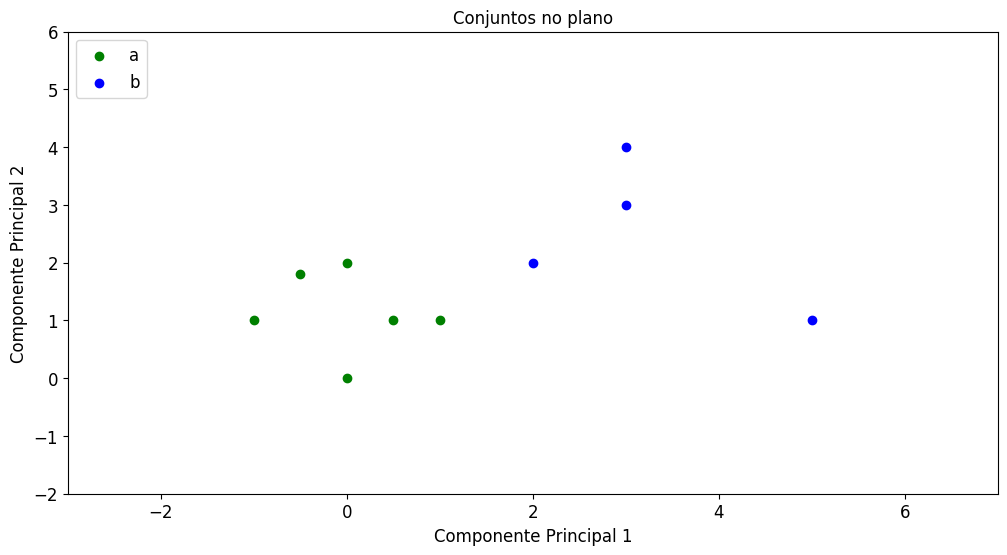

In [197]:
# Conjuntos

label_a = "a"
label_b = "b"

set_a = [Sample(-0.5, 1.8, label_a), Sample(0, 0, label_a), Sample(0.5, 1, label_a), Sample(0, 2, label_a), Sample(1, 1, label_a), Sample(-1, 1, label_a)]
set_b = [Sample(2, 2, label_b), Sample(3, 4, label_b), Sample(5, 1, label_b), Sample(3, 3, label_b)]

plot_sets(set_a, set_b, label_a, label_b)

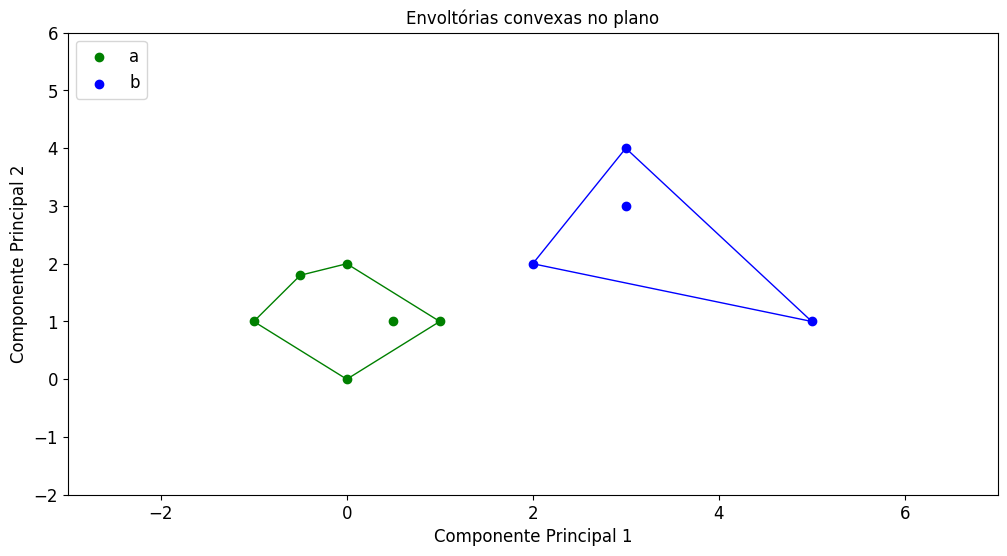

In [198]:
# Envoltórias Convexas

hull_a = graham_scan(set_a)
hull_b = graham_scan(set_b)

plot_hulls(set_a, set_b, hull_a, hull_b, label_a, label_b)

In [194]:
# Verificar se as duas envoltórias são linearmente separáveis

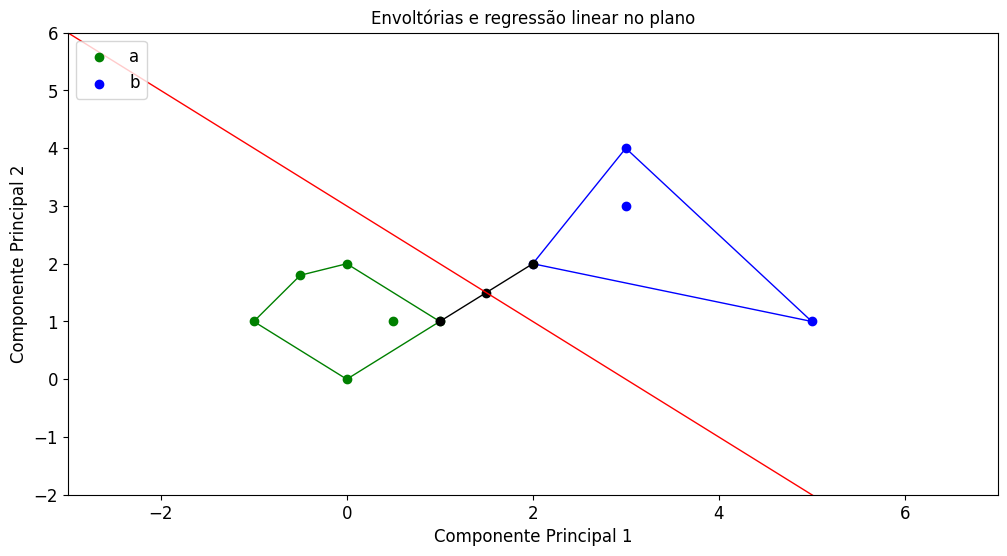

In [199]:
# Classificador
b0, b1, point_a, point_b, up_label, down_label = make_classifier(hull_a, hull_b, label_a, label_b)

plot_classifier(set_a, set_b, hull_a, hull_b, b0, b1, point_a, point_b, label_a, label_b)

In [205]:
# Exemplo de classificação de uma amostra

sample = Sample(-2, 3, label_a)

print(f"Coordenadas da amostra: ({sample.x}, {sample.y})")

classification = classify_sample(b0, b1, up_label, down_label, sample)

if classification == False:
    print("Amostra está sob a reta de regressão.")
else:
    if classification == sample.label:
        print(f"A amostra foi classificada corretamente! (Classificação: {classification} - Ground Truth: {sample.label})")
    else:
        print(f"A amostra não foi classificada corretamente. (Classificação: {classification} - Ground Truth: {sample.label})")

Coordenadas da amostra: (-2, 3)
A amostra foi classificada corretamente! (Classificação: a - Ground Truth: a)


## __Experimentação__

Aqui serão descritos os experimentos com os datasets retirados do KEEL.

In [138]:
# URL e importação dos datasets

WINES = "../data/csv/wine.csv"
TIC_TAC_TOE = "../data/csv/tic-tac-toe.csv"
MUSHROOM = "../data/csv/mushroom.csv"
MAGIC = "../data/csv/magic.csv"
IRIS = "../data/csv/iris.csv"
CHESS = "../data/csv/chess.csv"
CAR = "../data/csv/car.csv"
BANANA = "../data/csv/banana.csv"
LETTER = "../data/csv/letter.csv"
TITANIC = "../data/csv/titanic.csv"

wines_df = pd.read_csv(WINES, sep=',')
tic_tac_toe_df = pd.read_csv(TIC_TAC_TOE, sep=',')
mushroom_df = pd.read_csv(MUSHROOM, sep=',')
magic_df = pd.read_csv(MAGIC, sep=',')
iris_df = pd.read_csv(IRIS, sep=',')
chess_df = pd.read_csv(CHESS, sep=',')
car_df = pd.read_csv(CAR, sep=',')
banana_df = pd.read_csv(BANANA, sep=',')
letter_df = pd.read_csv(LETTER, sep=',')
titanic_df = pd.read_csv(TITANIC, sep=',')

In [139]:
# Definição do PCA e do número de componentes desejadas
pca = PCA(n_components=2)

## Titanic

In [163]:
# Normalizando os valores para fazer o PCA

features = ['TicketClass', 'Age', 'Sex']
classes = [int(x) for x in titanic_df['Class'].unique()]

samples = titanic_df.loc[:, features].values
label = titanic_df.loc[:,['Class']].values

samples = StandardScaler().fit_transform(samples)

# PCA do dataset
titanic_pca = pca.fit_transform(samples)

set_a = []
set_b = []

# Montando os dois conjuntos encapsulados pela classe Sample
for i, item in enumerate(titanic_pca):
    if label[i] == classes[0]:
        set_a.append(Sample(item[0], item[1], str(classes[0])))
    else:
        set_b.append(Sample(item[0], item[1], str(classes[1])))


        
# hull_a = graham_scan(set_a)
# hull_b = graham_scan(set_b)
        
# if hulls_are_linearly_separable(hull_a, hull_b) == False:
#     print("Os dois conjuntos não são linearmente independentes!")
# else:
#     b0, b1, _, _, up_label, down_label = make_classifier(hull_a, hull_b, classes[0], classes[1])

## __Resultados e Conclusões__